<a href="https://colab.research.google.com/github/swilsonmfc/pandas/blob/main/12_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12 Solution

# Install

In [110]:
!pip install pycaret
!pip install shap

# Setup

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from pycaret.classification import *
from pycaret.datasets import get_data

# Vectorize

In [112]:
# Make a fake dataset
X, y = make_blobs(n_samples=10_000_000, n_features=10)
np.savetxt('out.csv', X, delimiter=',')

In [113]:
# Assign to Frame & Name columns
X_df = pd.DataFrame(X)
X_df.columns = [f'col_{i}' for i in range(10)]

In [114]:
# Change the following statement to vectorized
def complex(row):
  value = row['col_0'] * row['col_1'] + row['col_2'] - row['col_3']
  if value > 0:
    return 1
  return -1

# Apply first 
sample = X_df[0:1000].apply(complex, axis=1)

In [115]:
# Vectorize into a column called complex
X_df['complex'] = np.where(X_df.col_0 * X_df.col_1 + X_df.col_2 - X_df.col_3 > 0, 1, -1)

# Data Types

In [116]:
# Measure memory
X_df.memory_usage(deep=True).sum()

880000128

In [117]:
# Convert float64 columns to np.float32
for col in X_df.columns:
  X_df[col] = X_df[col].astype(np.float32)

In [118]:
# Measure memory
X_df.memory_usage(deep=True).sum()

440000128

# Chunking

In [119]:
# Produce a sum of each column using chunking (1,000,000 rows per chunk)
sums = []
chunks = pd.read_csv('out.csv', chunksize=1_000_000)
for chunk in chunks:
  sums.append(chunk.sum(axis=0));
np.sum(sums, axis=0)

array([ -4125516.68785611, -49861647.86438495,  24358117.10715117,
        -7103738.30284688,  31957766.19657128,  36161768.52858459,
        15531109.49147658, -11389623.64872703, -13324268.63245722,
        66369464.05867369])

# Parquet

In [120]:
# Save as parquet
X_df.to_parquet('out.parquet')

In [121]:
# Compare file sizes
!ls -al

total 2881544
drwxr-xr-x 1 root root       4096 Nov  4 20:40 .
drwxr-xr-x 1 root root       4096 Nov  4 17:42 ..
drwxr-xr-x 4 root root       4096 Nov  1 13:34 .config
-rw-r--r-- 1 root root     145712 Nov  4 20:37 logs.log
-rw-r--r-- 1 root root 2542950507 Nov  4 20:51 out.csv
-rw-r--r-- 1 root root  407574713 Nov  4 20:52 out.parquet
drwxr-xr-x 1 root root       4096 Nov  1 13:35 sample_data


In [122]:
# Time reading as csv
%%timeit -n1 -r1
pd.read_csv('out.csv')

1 loop, best of 1: 25.3 s per loop


In [123]:
# Time reading as parquet
%%timeit -n1 -r1
pd.read_parquet('out.parquet')

1 loop, best of 1: 2.14 s per loop


# PCA

In [124]:
# Pull Credit Data
credit_df = get_data('credit')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


In [125]:
# What's the shape (rows & columns)
credit_df.shape

(24000, 24)

In [126]:
# How are the features correlated?
credit_df.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
LIMIT_BAL,1.000000,0.021180,-0.218270,-0.101714,0.144507,-0.268426,-0.294676,-0.284380,-0.265448,-0.247575,-0.233043,0.280714,0.274099,0.278666,0.290353,0.290489,0.286108,0.193520,0.173436,0.205204,0.199620,0.218101,0.218140,-0.150709
SEX,0.021180,1.000000,0.012263,-0.026336,-0.101431,-0.055700,-0.069304,-0.068161,-0.060089,-0.053890,-0.045049,-0.029638,-0.029080,-0.021676,-0.019951,-0.013580,-0.013299,0.000644,0.001298,-0.010413,0.000425,-0.000465,-0.003797,-0.042947
EDUCATION,-0.218270,0.012263,1.000000,-0.145358,0.176561,0.104571,0.119802,0.110544,0.106165,0.095527,0.078108,0.023352,0.016922,0.011345,-0.000030,-0.008038,-0.009181,-0.035289,-0.031329,-0.040020,-0.041435,-0.040332,-0.037872,0.026885
MARRIAGE,-0.101714,-0.026336,-0.145358,1.000000,-0.416894,0.019407,0.022402,0.033555,0.032382,0.036423,0.035385,-0.022476,-0.019796,-0.023555,-0.020691,-0.024526,-0.019138,-0.005835,-0.006871,-0.001834,-0.012067,-0.000706,-0.002401,-0.024888
AGE,0.144507,-0.101431,0.176561,-0.416894,1.000000,-0.042074,-0.048828,-0.052082,-0.048990,-0.057105,-0.053873,0.057860,0.055817,0.054577,0.052435,0.049805,0.047265,0.026669,0.022704,0.030798,0.020158,0.018961,0.022430,0.013450
PAY_1,-0.268426,-0.055700,0.104571,0.019407,-0.042074,1.000000,0.671551,0.571972,0.539503,0.510225,0.472995,0.190826,0.192881,0.183251,0.184385,0.185452,0.181012,-0.077027,-0.064965,-0.064386,-0.066933,-0.055933,-0.055712,0.323410
PAY_2,-0.294676,-0.069304,0.119802,0.022402,-0.048828,0.671551,1.000000,0.765295,0.660569,0.622181,0.576507,0.235201,0.235162,0.223533,0.223473,0.222790,0.221099,-0.079226,-0.057988,-0.051197,-0.047229,-0.035467,-0.033829,0.259680
PAY_3,-0.284380,-0.068161,0.110544,0.033555,-0.052082,0.571972,0.765295,1.000000,0.778626,0.687794,0.634889,0.207607,0.236877,0.226833,0.228636,0.226740,0.224067,0.004302,-0.063477,-0.047507,-0.046759,-0.035829,-0.034050,0.234374
PAY_4,-0.265448,-0.060089,0.106165,0.032382,-0.048990,0.539503,0.660569,0.778626,1.000000,0.818549,0.716921,0.202837,0.226135,0.245822,0.247250,0.244604,0.240982,-0.007009,-0.002460,-0.068376,-0.043696,-0.033070,-0.026423,0.216989
PAY_5,-0.247575,-0.053890,0.095527,0.036423,-0.057105,0.510225,0.622181,0.687794,0.818549,1.000000,0.815373,0.207503,0.227797,0.243881,0.273299,0.271816,0.264483,-0.004656,-0.003471,0.010366,-0.058308,-0.033591,-0.022649,0.206612


In [127]:
# Scale the data
X = credit_df.copy()
y = X.pop('default')

scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-1.13834487,  0.81493819,  0.1892966 , ..., -0.30909781,
        -0.31005791, -0.2899404 ],
       [-0.5994885 ,  0.81493819,  0.1892966 , ..., -0.24425398,
        -0.24512243, -0.01542366],
       [-0.90740643,  0.81493819,  0.1892966 , ..., -0.23776959,
        -0.24064189, -0.23503705],
       ...,
       [-1.06136539, -1.22708693,  0.1892966 , ..., -0.03675371,
        -0.18018696, -0.11974002],
       [-0.67646799, -1.22708693,  1.45938844, ..., -0.18420859,
         3.12918447, -0.19089476],
       [-0.90740643, -1.22708693,  0.1892966 , ..., -0.24425398,
        -0.24512243, -0.23503705]])

In [128]:
# Fit PCA
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [129]:
# How many components to get 80% explained?
explained = pca.explained_variance_ratio_.cumsum()
explained

array([0.28456189, 0.46199129, 0.53042924, 0.59509941, 0.63983036,
       0.68131259, 0.72092937, 0.75928026, 0.79708689, 0.8307622 ,
       0.86191804, 0.89167058, 0.9164552 , 0.93930152, 0.95680585,
       0.96817663, 0.97896643, 0.98716346, 0.99294125, 0.99606535,
       0.99785385, 0.99896173, 1.        ])

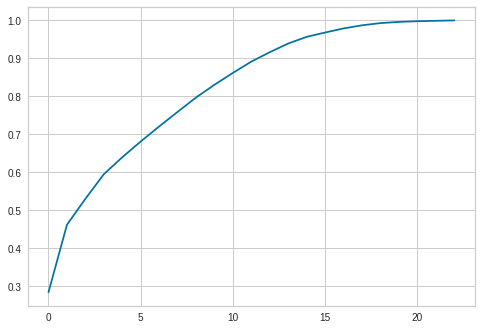

In [130]:
# Plot cumulative variance explained
plt.plot(explained)

In [131]:
# Build a PCA model with 10 components
pca10 = PCA(n_components=10)
X10 = pca10.fit_transform(X)
X10.shape

(24000, 10)

# PyCaret

In [132]:
# Reuse the credit_df dataframe.
# Notice that the dataset isn't balanced
credit_df.groupby('default').size()

default
0    18694
1     5306
dtype: int64

In [133]:
# Perform setup:
#   The target column is "default"
#   Use fix_imbalance=True
#   Normalize the data
clf = setup(credit_df, 'default', fix_imbalance=True, normalize=True)

,Description,Value
0,session_id,7060
1,Target,default
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(24000, 24)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [134]:
# Compare models on the dataset ~ 10 minutes
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8141,0.7676,0.4441,0.6124,0.5147,0.4033,0.4114,2.220
nb,Naive Bayes,0.8056,0.7274,0.2702,0.6613,0.3751,0.2856,0.3292,1.337
gbc,Gradient Boosting Classifier,0.8049,0.7704,0.4822,0.5721,0.5231,0.4016,0.4040,11.821
rf,Random Forest Classifier,0.8013,0.7561,0.4666,0.5637,0.5103,0.3872,0.3900,6.047
et,Extra Trees Classifier,0.7946,0.7335,0.4267,0.5489,0.4799,0.3545,0.3590,5.552
ada,Ada Boost Classifier,0.7821,0.7558,0.5259,0.5099,0.5174,0.3768,0.3771,3.583
svm,SVM - Linear Kernel,0.7778,0.0000,0.5339,0.5016,0.5156,0.3721,0.3734,1.774
ridge,Ridge Classifier,0.7757,0.0000,0.5612,0.4958,0.5263,0.3802,0.3815,2.027
lda,Linear Discriminant Analysis,0.7755,0.7640,0.5602,0.4955,0.5257,0.3794,0.3807,1.752
lr,Logistic Regression,0.7743,0.7678,0.5824,0.4934,0.5340,0.3865,0.3889,2.886


In [135]:
# Create a Logistic Regression Model
# There may be better performing models, stick to those you're familiar with or research them well!
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7726,0.7666,0.6016,0.4913,0.5409,0.3918,0.3953
1,0.7649,0.7716,0.5710,0.4754,0.5189,0.3650,0.3677
2,0.7815,0.7743,0.6113,0.5067,0.5541,0.4111,0.4143
3,0.7655,0.7610,0.5925,0.4773,0.5287,0.3750,0.3789
4,0.7940,0.7967,0.5979,0.5322,0.5631,0.4290,0.4302
5,0.7952,0.7916,0.6300,0.5329,0.5774,0.4435,0.4462
6,0.7673,0.7627,0.5764,0.4799,0.5238,0.3715,0.3742
7,0.7696,0.7561,0.5308,0.4829,0.5057,0.3560,0.3567
8,0.7440,0.7200,0.5147,0.4354,0.4717,0.3044,0.3063
9,0.7880,0.7775,0.5979,0.5198,0.5561,0.4177,0.4195


In [136]:
# Tune Model
lr_tuned = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7714,0.7666,0.6016,0.4891,0.5396,0.3897,0.3934
1,0.7655,0.7708,0.5710,0.4765,0.5195,0.3661,0.3687
2,0.7815,0.7743,0.6113,0.5067,0.5541,0.4111,0.4143
3,0.7655,0.7608,0.5925,0.4773,0.5287,0.3750,0.3789
4,0.7935,0.7966,0.5952,0.5311,0.5613,0.4268,0.4280
5,0.7952,0.7915,0.6300,0.5329,0.5774,0.4435,0.4462
6,0.7673,0.7626,0.5764,0.4799,0.5238,0.3715,0.3742
7,0.7696,0.7559,0.5308,0.4829,0.5057,0.3560,0.3567
8,0.7446,0.7200,0.5174,0.4367,0.4736,0.3066,0.3086
9,0.7874,0.7774,0.5979,0.5186,0.5554,0.4166,0.4184


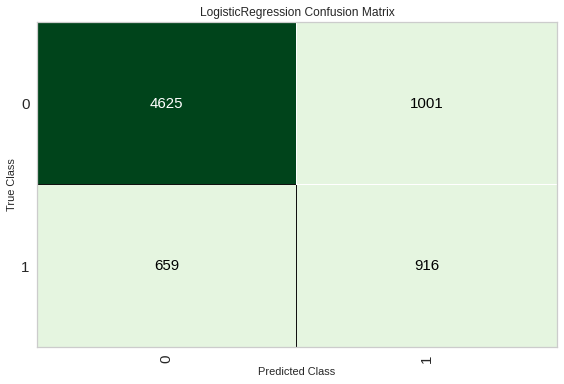

In [137]:
# Plot Confusion Matrix - What is the kind of error it's mostly making?
plot_model(lr_tuned, 'confusion_matrix')

In [138]:
# Predict on test data
predict_model(lr_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7695,0.7679,0.5816,0.4778,0.5246,0.3744,0.3775


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_-2,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_-2,PAY_2_0,...,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_-2,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_-2,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default,Label,Score
0,0.326927,-0.922471,0.403345,0.462016,0.530216,0.635155,0.763699,0.810122,-0.111231,-0.082581,-0.124875,-0.081267,-0.105213,-0.106832,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6720
1,0.480658,0.924987,0.045077,-0.527385,-0.603560,-0.576138,-0.415634,-0.359532,0.375461,-0.036609,0.063671,0.724747,0.849044,0.652327,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7056
2,2.402291,1.468357,5.459987,5.226995,3.998646,4.299510,4.716899,4.899852,0.568531,0.447333,0.313519,0.439129,0.440115,0.336168,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7154
3,0.250062,-0.813797,-0.631696,-0.689372,-0.632311,-0.629493,-0.665406,-0.651230,-0.355111,-0.129951,-0.301335,-0.324022,-0.314888,-0.120641,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.6051
4,-0.287996,0.272943,0.964643,1.023262,0.790422,0.736718,0.866310,0.911618,-0.044279,-0.082581,-0.110678,-0.099925,-0.092856,-0.114127,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,-0.672322,2.663772,0.224110,0.293860,-0.289325,-0.247083,-0.208942,-0.178888,0.272960,-0.199025,-0.242671,-0.247727,-0.245353,-0.211123,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6130
7197,0.096331,2.881120,-0.693287,-0.689372,-0.675107,-0.672585,-0.665406,-0.651230,-0.355111,-0.268892,-0.301335,-0.324022,-0.314888,-0.294645,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6429
7198,-0.902918,-1.357167,-0.628327,-0.467977,-0.433193,-0.422864,-0.360513,-0.331291,0.398574,-0.196650,-0.267369,-0.115946,-0.251164,-0.2629